# Building Models with Custom Activation Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For importing the MNIST data set:
from sklearn.datasets import fetch_openml

# For visualizing loop progress:
from tqdm import tqdm

# PyTorch imports:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset

### Activate the GPU for faster model training

To activate the GPU: \> Runtime \> Change runtime type \> Pick whatever GPU is available.

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
print("^^^^ if cuda is printed, we are using the GPU!")

cuda
^^^^ if cuda is printed, we are using the GPU!


### Load and visualize the MNIST data set

MNIST data loaded succesfully!
Image data: X.shape = (70000, 784)
Label data: y.shape = (70000,)



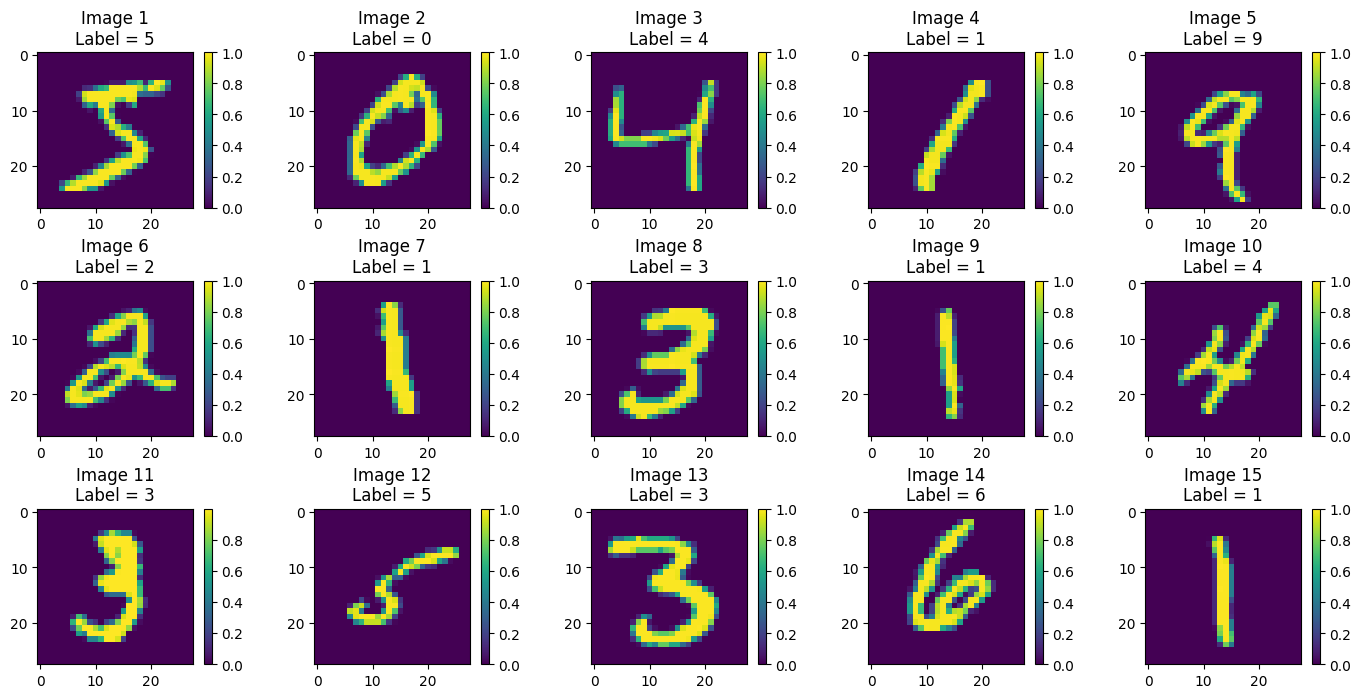

In [3]:
# Load the MNIST data:
mnist = fetch_openml("mnist_784", parser="auto")
X = np.array(mnist.data) / 255.0  # Scale the data to [0, 1]
y = np.array(mnist.target).astype(int)

# Print some data information:
print("MNIST data loaded succesfully!")
print(f"Image data: X.shape = {X.shape}")
print(f"Label data: y.shape = {y.shape}")
print()

# Plot some of the MNIST images.
plt.figure(figsize=(14, 7))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.title(f"Image {i + 1}\nLabel = {y[i]}")
    plt.imshow(X[i, :].reshape(28, 28))
    plt.colorbar()
plt.tight_layout()
plt.show()

### Process the data
- Pollute the data with Gaussian noise
- Mean-center every individual data point

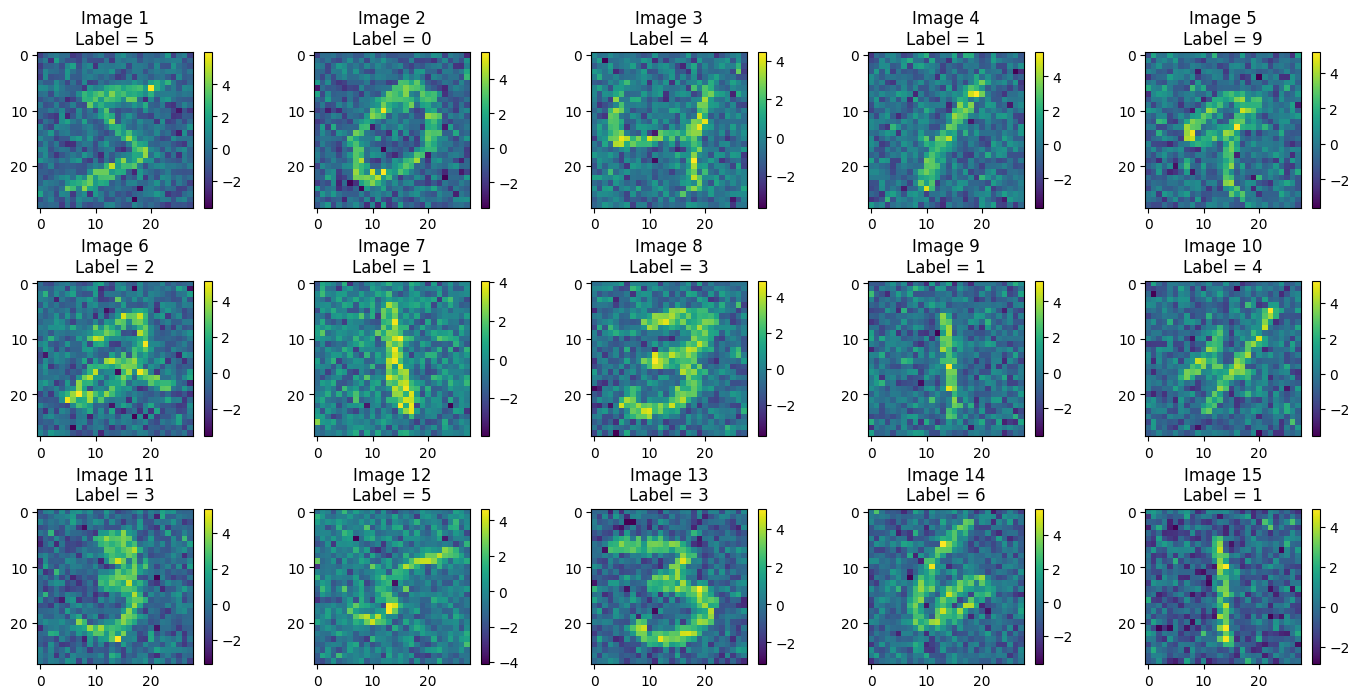

In [4]:
# Add Gaussian noise to the data.
X_norm = (X - np.mean(X)) / np.std(X)
X_noisy = X_norm + np.random.randn(*X.shape)

# Plot some of the noisy MNIST images.
plt.figure(figsize=(14, 7))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.title(f"Image {i + 1}\nLabel = {y[i]}")
    plt.imshow(X_noisy[i, :].reshape(28, 28))
    plt.colorbar()
plt.tight_layout()
plt.show()

### Convert the data for use by PyTorch:
- Convert NumPy arrays to PyTorch tensors
- Convert tensor data into PyTorch DataLoaders

In [5]:
# Split the data into a training and a test set.
# Reserve the first n_test samples for testing.
n_test = 10000 # <--- ADJUST THE TEST SET SIZE
X_train = X_noisy[n_test:]
y_train = y[n_test:]
X_test = X_noisy[:n_test]
y_test = y[:n_test]

# Convert data from NumPy arrays to PyTorch tensors.
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

print(f"X_train type: {type(X_train)}")
print(f"X_train size: {X_train.size()}")
print()
print(f"y_train type: {type(y_train)}")
print(f"y_train size: {y_train.size()}")
print()

# Use data tensors to build PyTorch Datasets.
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Use Datasets to build PyTorch DataLoaders.
batch_size = 512 # <--- ADJUST THE BATCH SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Note: DataLoaders are iterable, where each iteration yields a batch of data.
# Grab the first batch from the training loader to see dimensions.
batch_images, batch_labels = next(iter(train_loader))
print(f"batch_images size: {batch_images.size()}")
print(f"batch_labels size: {batch_labels.size()}")

X_train type: <class 'torch.Tensor'>
X_train size: torch.Size([60000, 784])

y_train type: <class 'torch.Tensor'>
y_train size: torch.Size([60000])

batch_images size: torch.Size([512, 784])
batch_labels size: torch.Size([512])


### Define the activation function

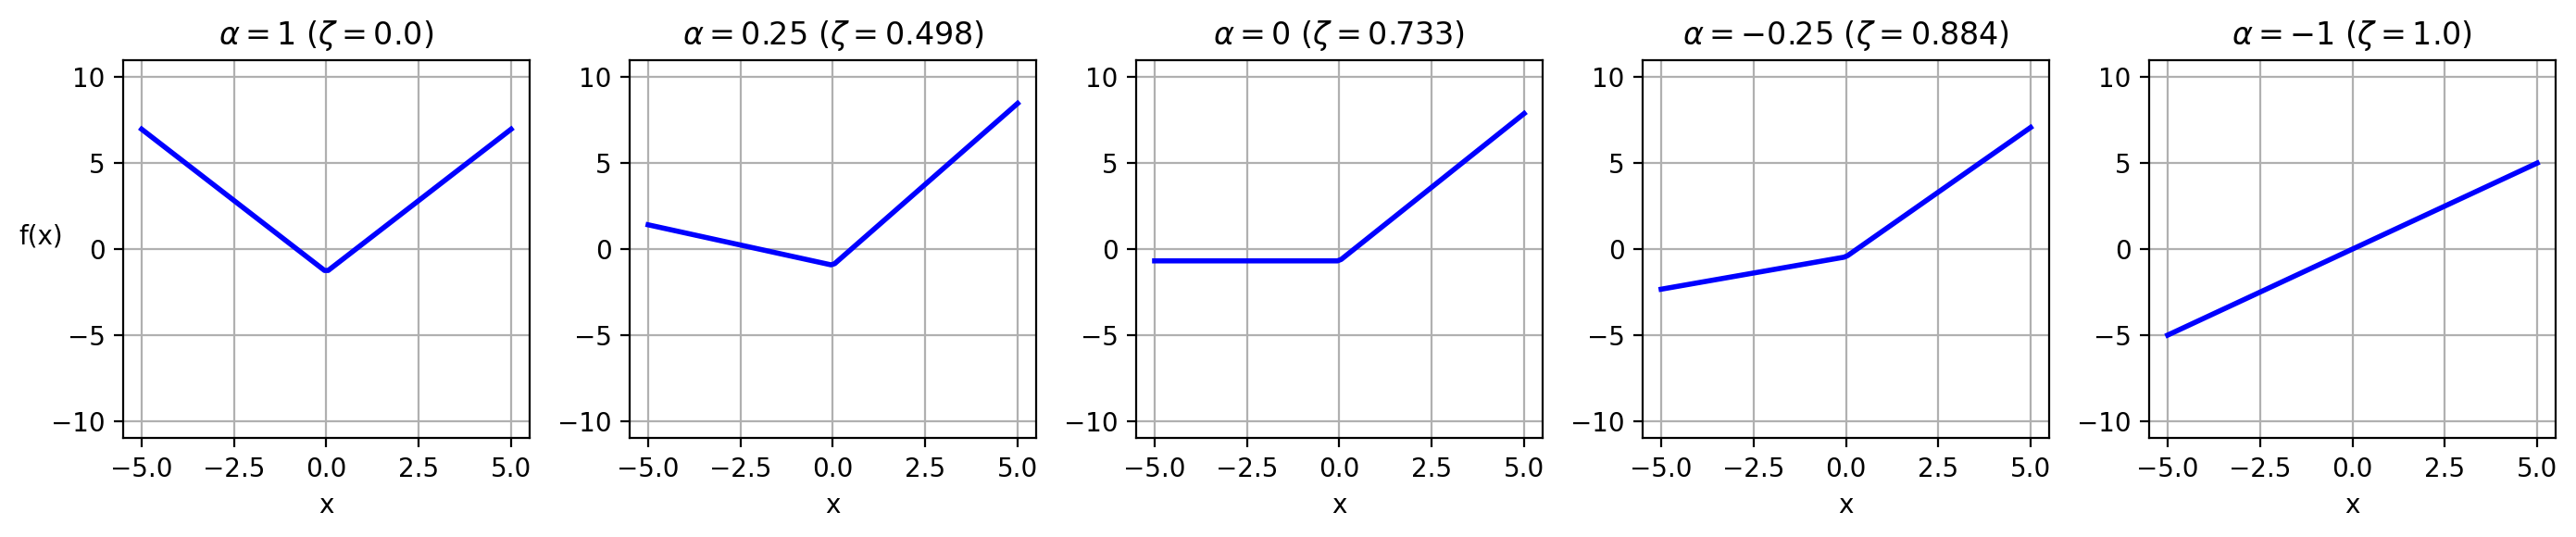

In [6]:
class ReLU_modified(nn.Module):
    def __init__(self, alpha):
        super(ReLU_modified, self).__init__()
        self._alpha = alpha

    def forward(self, x):
        scale = np.sqrt(0.5 * (1 + self._alpha ** 2) - 0.5 * (1 / np.pi) * (1 + self._alpha) ** 2)
        return (torch.relu(x) + self._alpha * torch.relu(-x) - (1 + self._alpha) / np.sqrt(2 * np.pi)) / scale

def compute_zeta(alpha):
    return (1 - alpha) ** 2 / (2 * (1 + alpha ** 2) - (2 / np.pi) * (1 + alpha) ** 2)

plt.figure(figsize=(14, 3), dpi=200)
x = torch.from_numpy(np.linspace(-5, 5, 100)).float()

for i, alpha in enumerate([1, 0.25, 0, -0.25, -1]):

    plt.subplot(1, 5, i + 1)
    title = "$\\alpha = {}$ $(\zeta = {})$"
    plt.title(title.format(alpha, np.round(compute_zeta(alpha), decimals=3)))
    plt.plot(x.numpy(), ReLU_modified(alpha)(x).numpy(), lw=2, c="b")
    plt.ylim([-11, 11])
    plt.xlabel("x")
    plt.grid()

    if i == 0:
        plt.ylabel("f(x)", rotation=0)

plt.tight_layout()
plt.show()

### Define the neural network architecture

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0, std=1/np.sqrt(m.in_features))

def compute_singular_values(model, X):
    Y = X.to(DEVICE)
    f = model[1]
    s_vals = []

    Y_init = X.cpu().detach().numpy()
    s = np.linalg.svd(Y_init, full_matrices=False, compute_uv=False)
    s_vals.append(s)

    for i, m in enumerate(model):
        if isinstance(m, nn.Linear):
            Y_new = f(m(Y)).cpu().detach().numpy()
            s = np.linalg.svd(Y_new, full_matrices=False, compute_uv=False)
            s_vals.append(s)
            Y = torch.from_numpy(Y_new).float().to(DEVICE)

    return s_vals

def tilted_ReLU_model(alpha):
    n0 = 28 * 28
    model = nn.Sequential(
        nn.Linear(n0, n0, bias=False),
        ReLU_modified(alpha),
        nn.Linear(n0, n0, bias=False),
        ReLU_modified(alpha),
        nn.Linear(n0, 10, bias=False),
    )
    model.apply(init_weights)
    return model

def ReLU_model():
    n0 = 28 * 28
    model = nn.Sequential(
        nn.Linear(n0, n0, bias=False),
        nn.ReLU(),
        nn.Linear(n0, n0, bias=False),
        nn.ReLU(),
        nn.Linear(n0, n0, bias=False),
    )
    model.apply(init_weights)
    return model

### TRAIN THE MODEL!

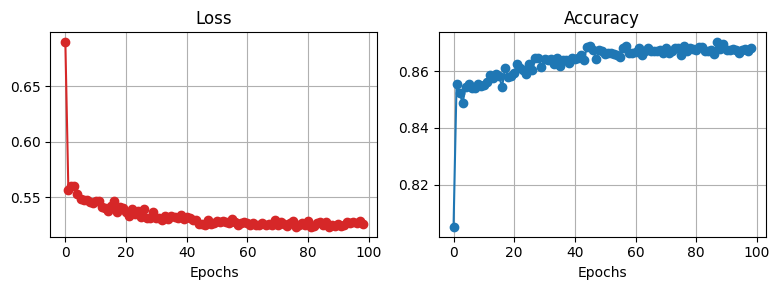

Test results:
Test loss: 0.5317414432764054
Test accuracy: 0.85302734375


In [10]:
# Initialize the neural network model.
# Be sure to load the model onto the GPU.

model = tilted_ReLU_model(alpha=1).to(DEVICE)
# model = ReLU_model().to(DEVICE)

# Compute the singular values of the layer outputs (before training).
s_vals_pretrain = compute_singular_values(model, X_train)

# Define the loss function.
loss_func = CrossEntropyLoss()

# Define the neural network optimizer.
# Pass the optimizer the NN parameters so that it can update them.
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.2) # <--- ADJUST THE LEARNING RATE

# Record loss and accuracy for every epoch.
all_train_loss = []
all_train_accuracy = []

# Train for some number of epochs.
# Alternatively, train until some accuracy tolerance is met.
# num_epochs = 100 # <--- ADJUST THE NUMBER OF TRAINING EPOCHS

tol = 1e-6
max_epochs = 100
current_epoch = 1
current_error = tol + 1.0

# for _ in tqdm(range(num_epochs)):
while current_epoch < max_epochs and current_error > tol:

    if current_epoch == 2:
        # Compute the singular values of the layer outputs (after training).
        s_vals_posttrain = compute_singular_values(model, X_train)

    # Prepare the model for training.
    model.train()

    # Initialize this epoch's loss and accuracy results.
    train_loss = 0.0
    train_accuracy = 0.0

    # Iterate over all images in the train loader to train the model.
    for images, labels in train_loader:

        # Load the data onto the GPU.
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()           # zero the gradient buffers
        pred = model(images)            # pass the images through the model
        loss = loss_func(pred, labels)  # compute cross entropy loss
        train_loss += loss.item()       # record the loss
        loss.backward()                 # compute gradients
        optimizer.step()                # update the model weights

        # Add to the total number of labels predicted correctly.
        pred_classes = torch.argmax(pred, dim=1)
        train_accuracy += torch.sum(pred_classes == labels).item()

    # Record the average loss across batches for this epoch.
    all_train_loss.append(train_loss / len(train_loader))

    # Record the accuracy ratio for this epoch.
    all_train_accuracy.append(train_accuracy / (batch_size * len(train_loader)))

    # Update epoch and tolerance information.
    if current_epoch > 1:
        current_error = np.abs(
            all_train_accuracy[current_epoch-1]
            - all_train_accuracy[current_epoch-2]
        )
    current_epoch += 1

# Plot the loss and accuracy across epochs.
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(all_train_loss, "o-", c="tab:red")
plt.title("Loss")
plt.xlabel("Epochs")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(all_train_accuracy, "o-", c="tab:blue")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.tight_layout()
plt.show()


# Test! Obtain the loss and the accuracy on the test set.
# Note the similarities and differences between training and testing.

# Prepare the model for evaluation.
model.eval()
test_loss = 0.0
test_accuracy = 0.0

# Since we aren't training the model, we make this specification.
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = loss_func(pred, labels)
        test_loss += loss.item()

        pred_classes = torch.argmax(pred, dim=1)
        test_accuracy += torch.sum(pred_classes == labels).item()

    test_loss /= len(test_loader)
    test_accuracy /= (batch_size * len(test_loader))

print("Test results:")
print("Test loss: " + str(test_loss))
print("Test accuracy: " + str(test_accuracy))

# alpha = 1

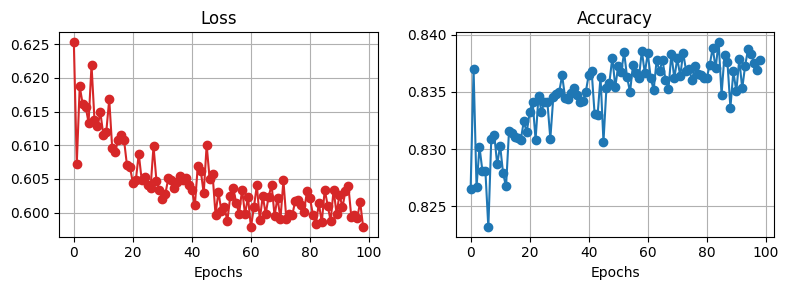

Test results:
Test loss: 0.6260466486215591
Test accuracy: 0.80625


In [9]:
# alpha = 0

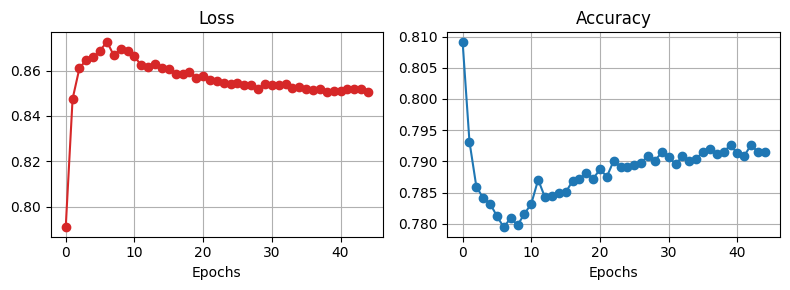

Test results:
Test loss: 0.851869523525238
Test accuracy: 0.78310546875


In [8]:
# alpha = -1